In [121]:
#load("../../dados/vra-wu.RData")
load("vw.RData")
#vra_wu=vra_wu[0:100000,]

###### Removendo algumas colunas que não devem ter utilizadade


In [ ]:
#Esse é o data set reduzido 'vw_modified'

vra_wu$autho_code = NULL #não sei o que é 
vra_wu$flight = NULL #Codigo do voo
vra_wu$airline = NULL #qual empresa
vra_wu$line_type = NULL #não sei o que é
vra_wu$observation = NULL #não sei o que é
vra_wu$duration_delta = NULL #diferenca de previsão
vra_wu$origin.state = NULL #
vra_wu$destiny.state = NULL #
vra_wu$arrival_expect_date = NULL #arrival_expect
vra_wu$arrival_expect_hour = NULL #arrival_expect
vra_wu$depart_expect_date = NULL #depart_expect
vra_wu$depart_expect_hour = NULL #depart_expect

###### Removendo todas as linhas que tem pelo menos um NA

In [47]:
#efetivamente removendo NA
vra_wu = vra_wu[rowSums(is.na(vra_wu))==0,]

#renomeando
vw <- vra_wu

ERROR: Error in save(vw, "vw.RData"): object 'vw.RData' not found


###### Removendo data de chegada menor que de partida, efetivo e estimado

In [50]:
vw = vw[vw$arrival>vw$depart,]
vw = vw[vw$arrival_expect>vw$depart_expect,]

###### Validando níveis de temperatura de forma exploratória

In [ ]:
min(vw$depart_temperature) #OK
max(vw$depart_temperature) #OK
min(vw$arrival_temperature) #OK
max(vw$arrival_temperature) #OK

###### pegando atrasos somente de 15min até 4 horas e que tem status 'Realizado'

In [122]:
vw = vw[vw$departure_delay >15 & vw$departure_delay <240 & vw$status=="Realizado",]

###### Top 5 aeroportos em contagem de atrasos de partida no brasil

In [123]:
library(dplyr)
vw_g = vw[c("origin")]
vw_g = vw_g %>% group_by(origin) %>% summarize(Count = n())
head(vw_g[order(-vw_g$Count),])
#SBGR=guarulhos, SBBR=brasilia, SBSP=congonhas, SBGL=galeão, SBSV=salvador, SBCF=belo horizonte

origin,Count
SBGR,65546
SBBR,35867
SBSP,33740
SBGL,32408
SBSV,30418
SBCF,22319


##### Análise do aeroporto de guarulhos

ERROR: Error in Ops.POSIXt(x, 2): '^' not defined for "POSIXt" objects


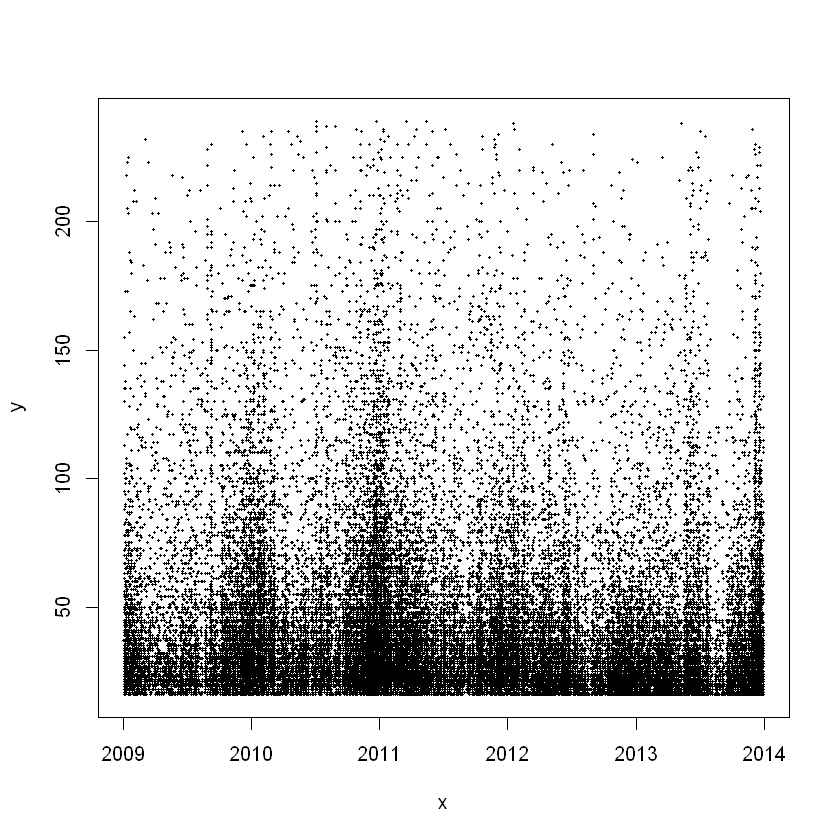

In [81]:
#vw_sbgr = vw[vw$origin == 'SBGR',]
#Filtrando 2014 pois 2016 e 2016 não estão completos
filter = vw_sbgr$depart$year+1900<2014 
x = vw_sbgr$depart[filter]
y = vw_sbgr$departure_delay[filter]
plot(x,y,pch=16 , cex=0.3)
#str(vw)

In [93]:
#dim(vra_wu)


[1] 8683195      37

In [99]:
a=colSums(is.na(vra_wu))
a[order(-a)]

arrival_visibility   depart_visibility       depart_events      arrival_events 
            2647816             2630157             1610187             1604697 
      arrival_delay      duration_delta     departure_delay     depart_pressure 
            1207611             1207611             1207610              951969 
   arrival_pressure             arrival            duration              depart 
             937069              830419              830419              830418 
  arrival_dew_point    depart_dew_point   depart_conditions  arrival_conditions 
             711880              707385              629570              625332 
   arrival_humidity     depart_humidity arrival_temperature  depart_temperature 
             589197              588613              581796              581273 
       origin.state       destiny.state arrival_expect_date arrival_expect_hour 
             455090              449946              377196              377196 
 depart_expect_date  depart_expect_hour       depart_expect      arrival_expect 
             377196              377196              377196              377196 
    duration_expect             destiny              origin             airline 
             377196                   0                   0                   0 
             flight          autho_code           line_type              status 
                  0                   0                   0                   0 
        observation 
                  0

Small delays < 300 min
Only considering flight with a delay, removing delay = 0

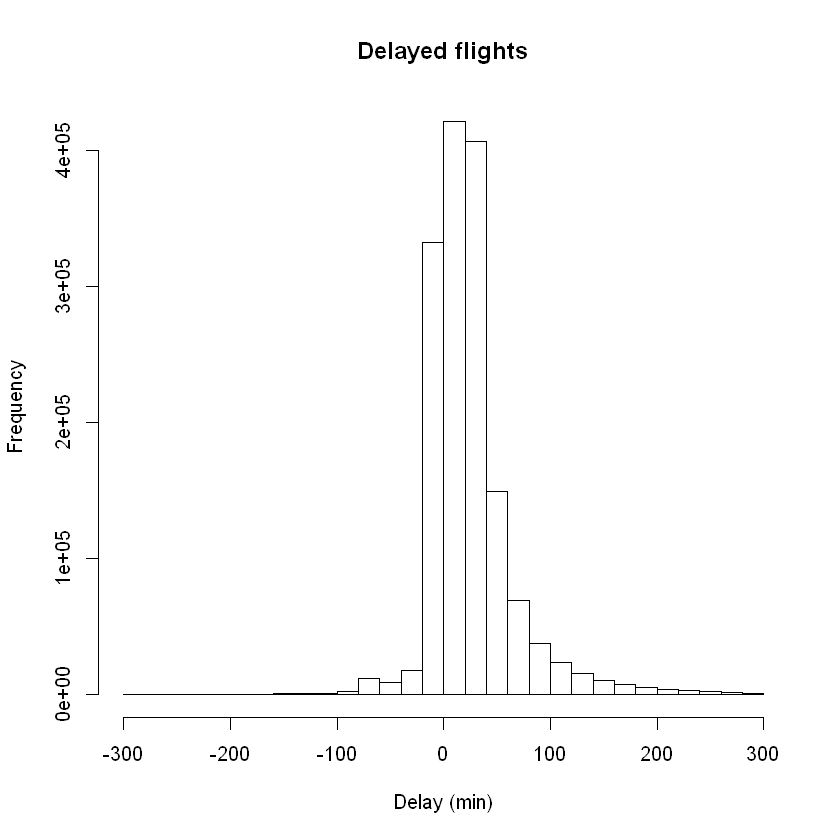

In [2]:
data=vra_wu[complete.cases(vra_wu$departure_delay),]
hist(data$departure_delay[data$status=="Realizado" 
      & data$departure_delay != 0 
      & abs(data$departure_delay) < 300]
     ,breaks=30
     ,xlim=c(-300,300)
     ,xlab="Delay (min)"
     ,main="Delayed flights"
     )
rm(data)

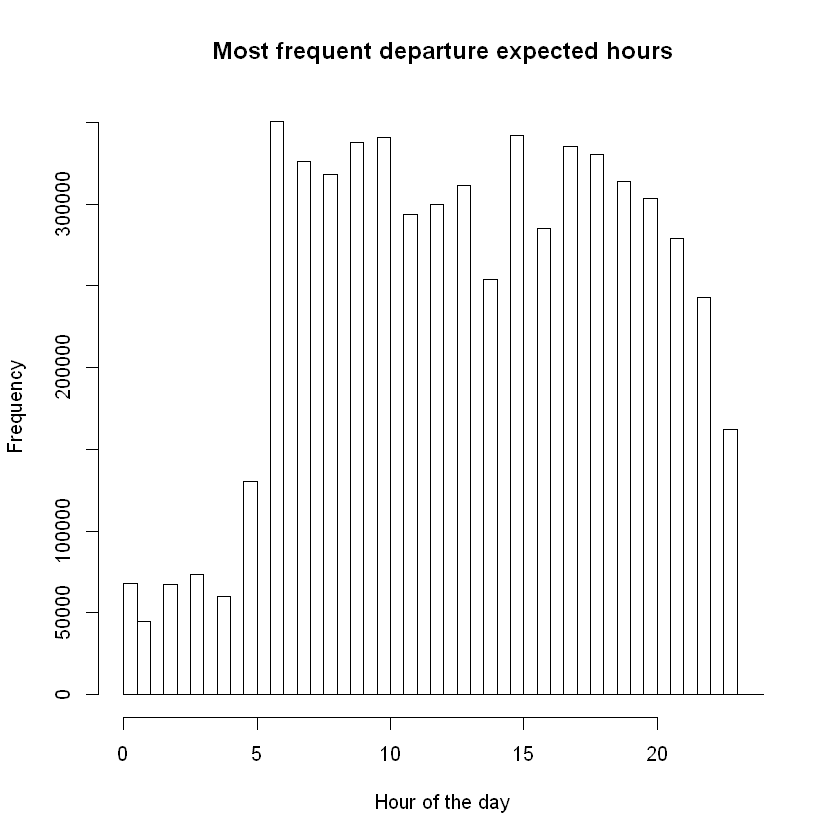

In [5]:
data=vra_wu[complete.cases(vra_wu$depart_expect_hour),]
deh = as.POSIXct(data$depart_expect_hour[data$status=="Realizado"], format="%H:%M")
deh = as.POSIXlt(deh)

h=hist(deh$hour+deh$min/60
     ,breaks=seq(0, 24, 0.5)
     ,xlim=c(0,24)
     ,xlab="Hour of the day"
     ,main="Most frequent departure expected hours"
     )
rm(data,deh)

###### Filtrando apenas dentro do Brasil

In [124]:
library(data.table)
airport = fread("https://raw.githubusercontent.com/gustavoP/DMcefet/master/airports_simplified.csv")

In [125]:
br_airport = select(airport[country == 'Brazil'],ICAO) 

vw = merge( vw, br_airport, by.x = "destiny", by.y = "ICAO")
vw = merge( vw, br_airport, by.x = "origin", by.y = "ICAO")

In [88]:
#a=colSums(is.na(vw))
#a[order(-a)]

#colnames(vw)

In [126]:
library(dplyr)
vw = vw[c("origin", "destiny")]
vw = vw %>% group_by(destiny,origin) %>% summarize(Count = n())

library(tidyverse)
vw$destiny = as.character(vw$destiny)
vw$origin = as.character(vw$origin)
vw = vw %>%
    rowwise() %>%
    mutate(grp = paste0(sort(c(destiny, origin)), collapse = "_")) %>%
    ungroup() %>%
    group_by(grp) %>%
    summarise(Count = sum(Count)) %>%
    separate(grp, into = c("destiny", "origin"))

dim(vw)

[1] 384   3

Filtrando alguns casos:
1) SaÃ­da e destino para o mesmo lugar.

In [127]:
#Join Departure
vra_wu<-vw
vra_wu= merge(vra_wu,airport, by.x="destiny", by.y="ICAO")
colnames(vra_wu)[colnames(vra_wu) == "name"] = "destiny_airport_name"
colnames(vra_wu)[colnames(vra_wu) == "city"] = "destiny_city"
colnames(vra_wu)[colnames(vra_wu) == "country"] = "destiny_country"
colnames(vra_wu)[colnames(vra_wu) == "latitude"] = "destiny_latitude"
colnames(vra_wu)[colnames(vra_wu) == "longitude"] = "destiny_longitude"

#Join Origin
vra_wu= merge(vra_wu,airport, by.x="origin", by.y="ICAO")
colnames(vra_wu)[colnames(vra_wu) == "name"] = "origin_airport_name"
colnames(vra_wu)[colnames(vra_wu) == "city"] = "origin_city"
colnames(vra_wu)[colnames(vra_wu) == "country"] = "origin_country"
colnames(vra_wu)[colnames(vra_wu) == "latitude"] = "origin_latitude"
colnames(vra_wu)[colnames(vra_wu) == "longitude"] = "origin_longitude"

In [107]:
#install.packages("tidyverse")
#install.packages("maps")
#install.packages("geosphere")
#install.packages("rgdal")

package 'rgdal' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\g_pac\AppData\Local\Temp\RtmpSwxYwm\downloaded_packages


###### Mapa do Brasil
Fonte: https://downloads.ibge.gov.br/downloads_geociencias.htm

In [113]:
library(rgdal)
#the "." is the directory where the BRUFE250GC_SIR.shp file is located
shp <- readOGR(".", "BRUFE250GC_SIR", stringsAsFactors=FALSE, encoding="UTF-8")

ibge <-read.csv(file="estadosibge.csv", header=FALSE, sep=",")
head(ibge)

pg <- merge(pg,ibge, by.x = "Estado", by.y = "UF")


ERROR: Error in ogrInfo(dsn = dsn, layer = layer, encoding = encoding, use_iconv = use_iconv, : Cannot open layer


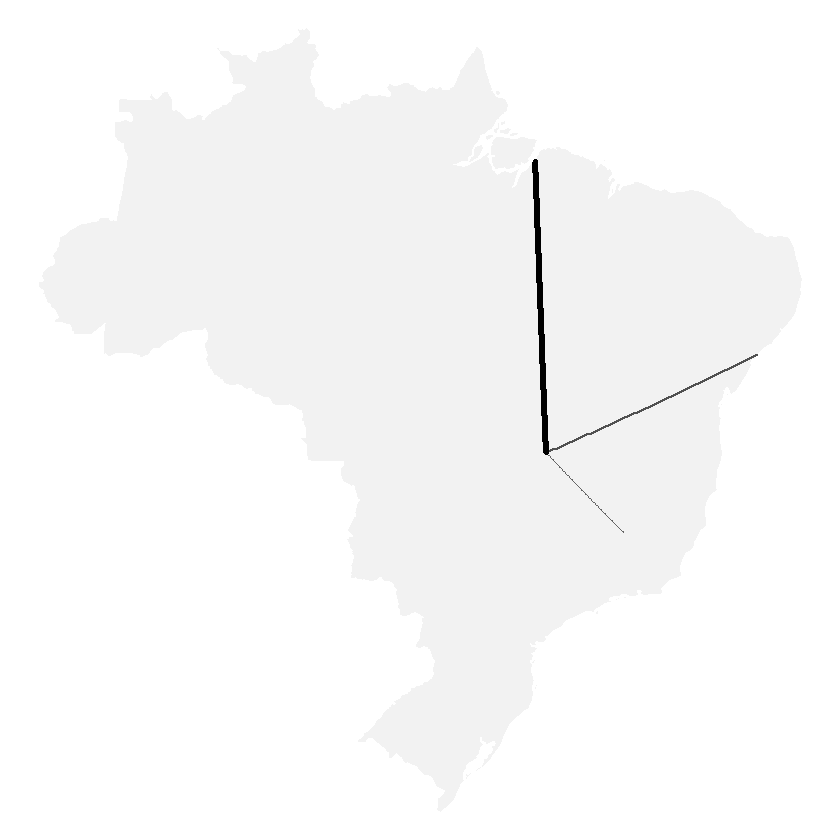

In [130]:
library(tidyverse)
library(maps)
library(geosphere)

vra_wu = vra_wu[vra_wu$origin == 'SBGR',]

par(mar=c(0,0,0,0))
map('world','Brazil',col="#f2f2f2", fill=TRUE, bg="white", lwd=0.05,mar=rep(0,4),border=0, resolution=0)
pal <- colorRampPalette(c("#666666", "black"))
colors <- pal(30)

max_cnt = max(vra_wu$Count)
min_cnt = min(vra_wu$Count)
lwd_max = 5
lwd_min = 0.8


for (j in 1:dim(vra_wu)[1]) {
    #j=15*i
    origin = c(vra_wu$origin_longitude[j],vra_wu$origin_latitude[j])
    destiny = c(vra_wu$destiny_longitude[j],vra_wu$destiny_latitude[j])
     
    inter = gcIntermediate(origin, destiny, n=100, addStartEnd=TRUE)
    pu = (vra_wu$Count[j] -min_cnt)/(max_cnt-min_cnt)
    col_index =1+ round(pu*(length(colors)-1))
    lin = pu*(lwd_max-lwd_min)+lwd_min
    lines(inter, col=colors[col_index],lwd=lin)
    #lines(inter, col="#666666",lwd=0.5)
    #min=0.8
    #if (i==100){break}
}


In [129]:
vra_wu


origin,destiny,Count,destiny_airport_name,destiny_city,destiny_country,destiny_latitude,destiny_longitude,origin_airport_name,origin_city,origin_country,origin_latitude,origin_longitude
SBBR,SBAR,508,Santa Maria Airport,Aracaju,Brazil,-10.98400,-37.0703,Presidente Juscelino Kubistschek International Airport,Brasilia,Brazil,-15.86917,-47.92083
SBBR,SBBH,1,Pampulha - Carlos Drummond de Andrade Airport,Belo Horizonte,Brazil,-19.85120,-43.9506,Presidente Juscelino Kubistschek International Airport,Brasilia,Brazil,-15.86917,-47.92083
SBBR,SBBE,2622,Val de Cans/JÃºlio Cezar Ribeiro International Airport,Belem,Brazil,-1.37925,-48.4763,Presidente Juscelino Kubistschek International Airport,Brasilia,Brazil,-15.86917,-47.92083
